<a href="https://colab.research.google.com/github/morteza80mr/DeepLearning2024/blob/main/Mini%20Project%202/Implementation_and_Training_of_GoogLeNet_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GoogLeNet inceptionV1**

In [8]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

**1) Define Inception Block**

Inception block as in GoogLeNet (Inception v1).We add optional batch normalization after each conv.

In [9]:
class Inception(nn.Module):
    def __init__(
        self,
        in_channels,
        out_1x1,
        red_3x3,
        out_3x3,
        red_5x5,
        out_5x5,
        out_pool,
        extra_param=None,  # Add extra parameter if needed
    ):
        super(Inception, self).__init__()

        # 1x1 branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(True),
        )

        # 1x1 -> 3x3 branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(True),
        )

        # 1x1 -> 5x5 branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(True),
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1, b2, b3, b4], 1)

**2) Define GoogLeNet-ish Model (adapted for CIFAR-10)**

A simplified/modified GoogLeNet for CIFAR-10 (32x32). We start with a 3x3 conv instead of 7x7, reduce some filter sizes, and maintain the Inception structure.

In [10]:
class GoogLeNetCIFAR(nn.Module):
    def __init__(self, num_classes=10, dropout=0.4):
        super(GoogLeNetCIFAR, self).__init__()

        # Stem: using smaller conv for 32x32
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True)
        )

        # MaxPool -> Inception(3a) -> Inception(3b) -> MaxPool
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception_3a = Inception(192,  64,  96, 128, 16, 32,  32)
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96,  64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception(4a) -> Inception(4b) -> Inception(4c) -> Inception(4d) -> Inception(4e) -> MaxPool
        self.inception_4a = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inception_4b = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inception_4c = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inception_4d = Inception(512, 112, 144, 288, 32,  64,  64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception(5a) -> Inception(5b) -> Average Pool
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)

        # Global Average Pool -> Dropout -> Linear
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Stem
        x = self.conv1(x)    # => [B,64,32,32]
        x = self.conv2(x)    # => [B,64,32,32]
        x = self.conv3(x)    # => [B,192,32,32]

        # Inception 3
        x = self.maxpool1(x) # => [B,192,16,16]
        x = self.inception_3a(x) # => [B,256,16,16]
        x = self.inception_3b(x) # => [B,480,16,16]
        x = self.maxpool2(x) # => [B,480,8,8]

        # Inception 4
        x = self.inception_4a(x) # => [B,512,8,8]
        x = self.inception_4b(x) # => [B,512,8,8]
        x = self.inception_4c(x) # => [B,512,8,8]
        x = self.inception_4d(x) # => [B,528,8,8]
        x = self.inception_4e(x) # => [B,832,8,8]
        x = self.maxpool3(x)     # => [B,832,4,4]

        # Inception 5
        x = self.inception_5a(x) # => [B,832,4,4]
        x = self.inception_5b(x) # => [B,1024,4,4]

        # Global AvgPool -> FC
        x = self.avgpool(x)      # => [B,1024,1,1]
        x = torch.flatten(x, 1)  # => [B,1024]
        x = self.dropout(x)
        x = self.linear(x)       # => [B,num_classes]
        return x

**3) Weight Initialization (Xavier)**

In [11]:
def xavier_init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

**4) Data Preparation: use only 20,000 TRAIN images**

In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

full_train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

# Randomly pick 20,000 indices out of the total 50,000
indices = torch.randperm(len(full_train_dataset))[:20000]
train_subset = Subset(full_train_dataset, indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)

# Test dataset remains the full CIFAR-10 test set
test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**5) Instantiate Model, Optimizer, Criterion**

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GoogLeNetCIFAR(num_classes=10, dropout=0.4).to(device)

# Weight initialization
xavier_init_weights(model)

# Adam with LR=0.001 and weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

**6) Training & Validation Loops (with epoch duration)**

In [14]:
EPOCHS = 20

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    start_time = time.time()  # measure epoch start

    # ------------- TRAIN -------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ------------- VALIDATION -------------
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct_test += predicted.eq(labels).sum().item()
            total_test += labels.size(0)

    test_epoch_loss = test_running_loss / total_test
    test_epoch_acc = 100.0 * correct_test / total_test
    test_losses.append(test_epoch_loss)
    test_accs.append(test_epoch_acc)

    epoch_time = time.time() - start_time  # measure epoch end

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Duration: {epoch_time:.2f}s\n"
          f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%\n"
          f"  Test  Loss: {test_epoch_loss:.4f}, Test  Acc: {test_epoch_acc:.2f}%\n")

Epoch [1/20] | Duration: 29.36s
  Train Loss: 1.7332, Train Acc: 38.98%
  Test  Loss: 1.3701, Test  Acc: 50.46%

Epoch [2/20] | Duration: 27.79s
  Train Loss: 1.2819, Train Acc: 54.27%
  Test  Loss: 1.2826, Test  Acc: 55.11%

Epoch [3/20] | Duration: 28.56s
  Train Loss: 1.0065, Train Acc: 64.67%
  Test  Loss: 1.2264, Test  Acc: 61.11%

Epoch [4/20] | Duration: 28.84s
  Train Loss: 0.8392, Train Acc: 71.03%
  Test  Loss: 1.0224, Test  Acc: 66.83%

Epoch [5/20] | Duration: 28.98s
  Train Loss: 0.6951, Train Acc: 76.14%
  Test  Loss: 0.8526, Test  Acc: 72.05%

Epoch [6/20] | Duration: 29.49s
  Train Loss: 0.6386, Train Acc: 78.46%
  Test  Loss: 0.8044, Test  Acc: 73.07%

Epoch [7/20] | Duration: 29.04s
  Train Loss: 0.5657, Train Acc: 80.64%
  Test  Loss: 0.7399, Test  Acc: 76.23%

Epoch [8/20] | Duration: 28.87s
  Train Loss: 0.5146, Train Acc: 82.53%
  Test  Loss: 0.5833, Test  Acc: 80.38%

Epoch [9/20] | Duration: 28.59s
  Train Loss: 0.4577, Train Acc: 84.60%
  Test  Loss: 1.0244, Te

**7) Final Evaluation: Confusion Matrix, F1 Score**

In [15]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Compute confusion matrix, F1 (weighted), final accuracy
cm = confusion_matrix(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average='weighted')
accuracy = 100.0 * (cm.trace() / cm.sum())

print("\nFinal Test Accuracy: {:.2f}%".format(accuracy))
print("Final F1 Score (weighted): {:.4f}".format(f1))
print("Confusion Matrix:\n", cm)


Final Test Accuracy: 82.93%
Final F1 Score (weighted): 0.8302
Confusion Matrix:
 [[807   8  27  25  36   4  11  14  56  12]
 [ 10 925   3   7   3   4   3   7  11  27]
 [ 27   0 687  49 114  67  44   9   3   0]
 [  6   1  21 642  47 221  38  16   5   3]
 [  0   0  11  24 884  57   9  15   0   0]
 [  2   0  15  55  25 883   8  11   1   0]
 [  3   1  15  26  39  28 885   0   1   2]
 [  3   0   3  22  44 100   1 824   1   2]
 [ 23   9   5  11   7   5   1   9 907  23]
 [ 19  57   3  15   6  17   2  22  10 849]]


**8) Plot the Loss Curves**

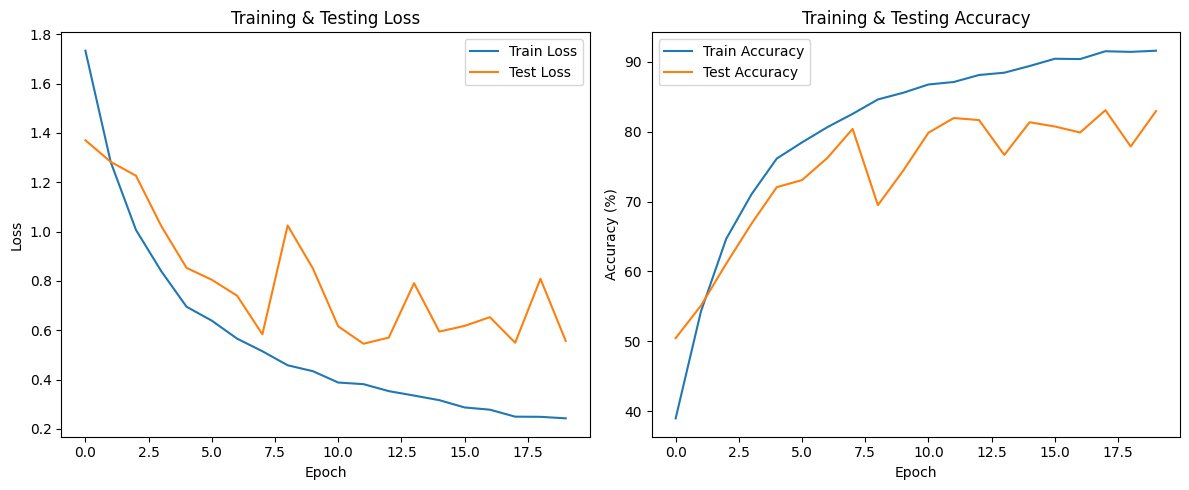

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), train_losses, label='Train Loss')
plt.plot(range(EPOCHS), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Testing Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), train_accs, label='Train Accuracy')
plt.plot(range(EPOCHS), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **GoogLeNet inceptionV2**

In [17]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

**1) Define the Factorized Inception Block**

    Inception block with factorized convolutions:
     - 1x1
     - 1x1 -> 1x5 -> 5x1
     - 1x1 -> 1x3 -> 3x1
     - 3x3 MaxPool -> 1x1
    Then concat all branches.

In [18]:
class InceptionFactorized(nn.Module):
    def __init__(self, in_channels, out_1x1,
                 red_5x5, out_5x5,
                 red_3x3, out_3x3,
                 pool_proj):
        """
        Args:
          in_channels: number of channels entering the block
          out_1x1: #channels for the pure 1x1 branch
          red_5x5: #channels in the reduce-5x5 branch (1x1 reduce)
          out_5x5: #channels out of the (1x5 + 5x1) stack
          red_3x3: #channels in the reduce-3x3 branch
          out_3x3: #channels out of the (1x3 + 3x1) stack
          pool_proj: #channels in the 1x1 after pooling
        """
        super(InceptionFactorized, self).__init__()

        # Branch 1: 1x1
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(True)
        )

        # Branch 2: 1x1 -> 1x5 -> 5x1
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(True),
            nn.Conv2d(red_5x5, red_5x5, kernel_size=(1,5), padding=(0,2)),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=(5,1), padding=(2,0)),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(True)
        )

        # Branch 3: 1x1 -> 1x3 -> 3x1
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(True),
            nn.Conv2d(red_3x3, red_3x3, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=(3,1), padding=(1,0)),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(True)
        )

        # Branch 4: 3x3 MaxPool -> 1x1
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(True)
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1, b2, b3, b4], 1)

**2) Example Network Using the Custom Inception Block**

(A very simplified "GoogLeNet-like" architecture)

In [19]:
class MiniGoogLeNetFactorized(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniGoogLeNetFactorized, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        # Just one or two InceptionFactorized blocks for demo
        self.inception1 = InceptionFactorized(
            in_channels=64,
            out_1x1=16,    # example
            red_5x5=16, out_5x5=16,
            red_3x3=16, out_3x3=16,
            pool_proj=16
        )
        self.inception2 = InceptionFactorized(
            in_channels=16+16+16+16,  # =64
            out_1x1=32,
            red_5x5=32, out_5x5=32,
            red_3x3=32, out_3x3=32,
            pool_proj=32
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(32+32+32+32, num_classes)

    def forward(self, x):
        x = self.conv1(x)           # => [B,64,H,W]
        x = self.inception1(x)      # => [B,64,H,W]
        x = self.inception2(x)      # => [B,128?, etc... Actually 32+32+32+32=128]
        x = self.global_pool(x)     # => [B,128,1,1]
        x = torch.flatten(x, 1)     # => [B,128]
        x = self.linear(x)          # => [B,10]
        return x

**3) Prepare CIFAR-10, but only 20,000 samples for training**

In [20]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

train_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Restrict train set to 20,000 samples
indices = torch.randperm(len(train_full))[:20000]
train_subset = Subset(train_full, indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**4) Instantiate Model + Train**

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MiniGoogLeNetFactorized().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 20

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(EPOCHS):
    start = time.time()

    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / total)
    train_accs.append(100.0 * correct / total)

    # Validation
    model.eval()
    test_loss, correct_t, total_t = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            l = criterion(out, labels)
            test_loss += l.item() * images.size(0)
            _, preds = out.max(1)
            correct_t += preds.eq(labels).sum().item()
            total_t += labels.size(0)
    test_losses.append(test_loss / total_t)
    test_accs.append(100.0 * correct_t / total_t)

    elapsed = time.time() - start
    print(f"Epoch {epoch+1}/{EPOCHS} [{elapsed:.1f}s]: "
          f"Train Loss {train_losses[-1]:.3f}, Train Acc {train_accs[-1]:.2f}% | "
          f"Test Loss {test_losses[-1]:.3f}, Test Acc {test_accs[-1]:.2f}%")

Epoch 1/20 [17.2s]: Train Loss 1.820, Train Acc 32.92% | Test Loss 1.655, Test Acc 37.39%
Epoch 2/20 [17.6s]: Train Loss 1.522, Train Acc 44.97% | Test Loss 1.460, Test Acc 46.81%
Epoch 3/20 [16.8s]: Train Loss 1.378, Train Acc 50.38% | Test Loss 1.369, Test Acc 49.62%
Epoch 4/20 [16.7s]: Train Loss 1.287, Train Acc 53.94% | Test Loss 1.271, Test Acc 54.73%
Epoch 5/20 [15.9s]: Train Loss 1.232, Train Acc 56.39% | Test Loss 1.231, Test Acc 56.12%
Epoch 6/20 [16.5s]: Train Loss 1.162, Train Acc 58.88% | Test Loss 1.234, Test Acc 55.70%
Epoch 7/20 [16.6s]: Train Loss 1.129, Train Acc 60.03% | Test Loss 1.173, Test Acc 57.95%
Epoch 8/20 [16.8s]: Train Loss 1.096, Train Acc 61.31% | Test Loss 1.115, Test Acc 60.20%
Epoch 9/20 [16.6s]: Train Loss 1.058, Train Acc 62.55% | Test Loss 1.088, Test Acc 60.90%
Epoch 10/20 [16.8s]: Train Loss 1.036, Train Acc 63.65% | Test Loss 1.159, Test Acc 57.64%
Epoch 11/20 [16.8s]: Train Loss 0.998, Train Acc 65.05% | Test Loss 1.045, Test Acc 62.82%
Epoch 12

**Final evaluation**

In [22]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        _, preds = logits.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
acc = 100.0 * cm.trace() / cm.sum()

print(f"\nFinal Test Accuracy: {acc:.2f}%")
print(f"F1 Score (weighted): {f1:.4f}")
print("Confusion Matrix:\n", cm)


Final Test Accuracy: 67.19%
F1 Score (weighted): 0.6615
Confusion Matrix:
 [[740  42  32   6  10   2  11  22 103  32]
 [ 60 797   4   1   2   1   2   9  16 108]
 [119   8 499  15 136  45  90  69  14   5]
 [ 35  30  98 272  84 244 110  80  27  20]
 [ 22   7  68  17 640  32  78 105  22   9]
 [ 25   8  54  79  76 585  29 118  16  10]
 [ 18   3  55  38  53  23 786  14   4   6]
 [ 27   6  32  12  93  52   8 746   4  20]
 [ 78  29   8   3   9   1   6   6 833  27]
 [ 33  77   3   3   8   0   5  17  33 821]]


Plotting the curves

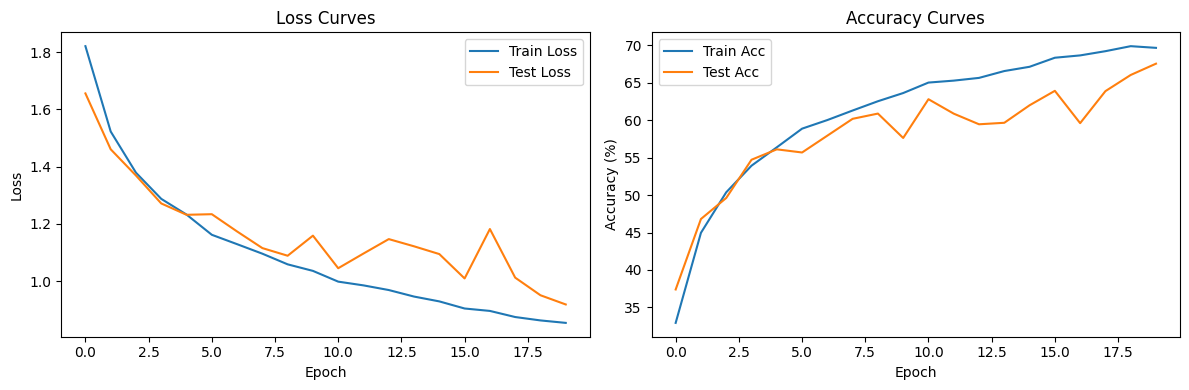

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Curves'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves'); plt.legend()

plt.tight_layout()
plt.show()

# **GoogLeNet inceptionV3**

In [24]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

**1) Data Preparation: CIFAR-10 => Resized to 299x299**

(Pick Only 20k Samples from the Train Set)

In [25]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),       # Upscale from 32x32 to ~299x299
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

test_transform = transforms.Compose([
    transforms.Resize(320),      # slightly larger
    transforms.CenterCrop(299),  # then center-crop to 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

train_full = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)
test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# Restrict train set to 20,000 samples
indices = torch.randperm(len(train_full))[:20000]
train_subset = Subset(train_full, indices)

# Hyperparameter to tune: batch size
BATCH_SIZE = 64

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**2) Load InceptionV3 and Adjust for CIFAR-10**

In [26]:
# If you want the model weights, you could do pretrained=True to fine-tune.
# model = models.inception_v3(pretrained=False, aux_logits=True)
# For a pretrained approach (recommended):
model = models.inception_v3(pretrained=True, aux_logits=True)

# Replace final FC for 10 classes (CIFAR-10)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Replace AuxLogits FC if aux_logits=True
if model.aux_logits:
    num_aux_features = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_aux_features, 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 109MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

**3) Define Loss & Optimizer**

In [27]:
learning_rate = 1e-3
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Optional: an LR scheduler can be added
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

**4) Training Loop**

In [28]:
EPOCHS = 20
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        # During training, InceptionV3 returns (logits, aux_logits) if aux_logits=True
        outputs, aux_out = model(images)

        loss_main = criterion(outputs, labels)
        loss_aux = 0
        if model.aux_logits:
            loss_aux = criterion(aux_out, labels) * 0.4
        loss = loss_main + loss_aux

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss_epoch = running_loss / total
    train_acc_epoch = 100.0 * correct / total
    train_losses.append(train_loss_epoch)
    train_accs.append(train_acc_epoch)

    # scheduler.step()  # if using a scheduler

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # In eval mode, inception_v3 returns only the main output
            out = model(images)
            loss_val = criterion(out, labels)

            val_running_loss += loss_val.item() * images.size(0)
            _, predicted = out.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)

    val_loss_epoch = val_running_loss / val_total
    val_acc_epoch = 100.0 * val_correct / val_total
    test_losses.append(val_loss_epoch)
    test_accs.append(val_acc_epoch)

    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Time: {epoch_time:.2f}s\n"
          f"  Train Loss: {train_loss_epoch:.4f}, Train Acc: {train_acc_epoch:.2f}%\n"
          f"  Test  Loss: {val_loss_epoch:.4f}, Test  Acc: {val_acc_epoch:.2f}%\n")

Epoch [1/20] | Time: 335.28s
  Train Loss: 1.9515, Train Acc: 51.08%
  Test  Loss: 1.2618, Test  Acc: 60.07%

Epoch [2/20] | Time: 334.91s
  Train Loss: 1.5231, Train Acc: 61.35%
  Test  Loss: 0.8638, Test  Acc: 70.67%

Epoch [3/20] | Time: 334.30s
  Train Loss: 1.3786, Train Acc: 65.42%
  Test  Loss: 0.7559, Test  Acc: 74.77%

Epoch [4/20] | Time: 334.59s
  Train Loss: 1.2635, Train Acc: 68.78%
  Test  Loss: 0.6846, Test  Acc: 78.01%

Epoch [5/20] | Time: 333.39s
  Train Loss: 1.1897, Train Acc: 70.34%
  Test  Loss: 0.6957, Test  Acc: 76.51%

Epoch [6/20] | Time: 333.91s
  Train Loss: 1.1477, Train Acc: 71.42%
  Test  Loss: 0.5199, Test  Acc: 82.61%

Epoch [7/20] | Time: 333.56s
  Train Loss: 1.1065, Train Acc: 72.72%
  Test  Loss: 0.6074, Test  Acc: 80.23%

Epoch [8/20] | Time: 333.37s
  Train Loss: 1.0830, Train Acc: 73.15%
  Test  Loss: 0.4904, Test  Acc: 83.34%

Epoch [9/20] | Time: 333.32s
  Train Loss: 1.0530, Train Acc: 74.21%
  Test  Loss: 0.5332, Test  Acc: 81.79%

Epoch [10/

**5) Final Evaluation**

In [29]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = 100.0 * cm.trace() / cm.sum()

print(f"Final Test Accuracy: {accuracy:.2f}%")
print(f"F1 Score (weighted): {f1:.4f}")
print("Confusion Matrix:\n", cm)

Final Test Accuracy: 85.27%
F1 Score (weighted): 0.8532
Confusion Matrix:
 [[864   9  24  15   2   2  23   4  22  35]
 [  2 787   1   2   0   0  20   1   2 185]
 [ 32   1 758  44  26  23  93  15   4   4]
 [ 10   2  10 805  19  82  53  13   2   4]
 [  4   0  14  38 791  10 110  33   0   0]
 [  2   0  10 118  22 776  37  32   0   3]
 [  4   0   2  21   0   2 970   0   0   1]
 [  8   0   2  20  15  16  18 914   0   7]
 [ 37  10   8   6   0   0  25   0 897  17]
 [  5   8   3   2   0   0   7   2   8 965]]


**6) Plot Curves**

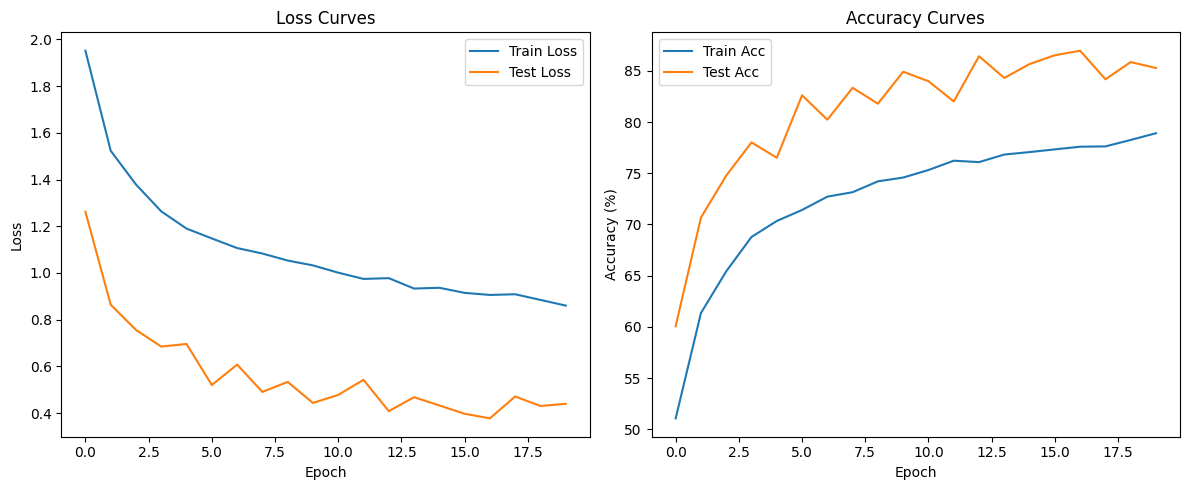

In [30]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), train_losses, label='Train Loss')
plt.plot(range(EPOCHS), test_losses,  label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Curves'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), train_accs, label='Train Acc')
plt.plot(range(EPOCHS), test_accs,  label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves'); plt.legend()

plt.tight_layout()
plt.show()